In [1]:
"""
 * \file
     *  MLoN CA3 Deep Neural Network
 * \author
 *  Wenqing Yan <wenqing.yan@it.uu.se>
 * Lib: mxnet, gluon
                 
"""

## Read the clean data
import pandas as pd
import numpy as np
import time
import mxnet as mx
import time
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, data as gdata, loss as gloss 

# Power consumption data
df_p = pd.read_csv('household_power_consumption.csv')
# Communities and crime data
df_c = pd.read_csv('communities_crime.csv')

In [201]:
# change df to mxnet nd array
p_features = mx.nd.array(df_p.iloc[:, 0:7].values)
p_labels = mx.nd.array(df_p.iloc[:, -2].values)
N_p=len(df_p)

In [202]:
# change df to mxnet nd array
c_features = mx.nd.array(df_c.iloc[:, 0:100].values)
c_labels = mx.nd.array(df_c.iloc[:, 100].values)
N_c=len(df_c)
square_loss = gluon.loss.L2Loss()

## L2Loss
\begin{equation*}
f(w) = \frac{1}{N} \sum_i \vert {label}_i - {pred}_i \vert^2.
\end{equation*}
## Sigmod
\begin{equation*}
s(x) = \frac{1}{1+\exp(-x)}
\end{equation*}
## Objective Function
\begin{equation*}
f(x) = \frac{1}{N} \sum_{i \in N} \|w_3s(W_2s(W_1x_i) - y_i \|^2
\end{equation*}

### Mxnet lib, 
Either you can use module gluon.Trainer() or naive method to build neural network. 
In this demo, we show both.

# GD

In [203]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train_gd(batch_size, lr, epochs, period, layers, features, labels):
    # Helps detect problems early in program by testing condition
    assert period >= batch_size and period % batch_size == 0
    mx.random.seed(1)
    random.seed(1)

    dataset = gluon.data.ArrayDataset(features, labels)

    # Stacks blocks sequentially
    net = gluon.nn.Sequential()
    # Adds block on top of the stacks
    net.add(gluon.nn.Dense(layers[0], activation='sigmoid'))
    net.add(gluon.nn.Dense(layers[0], activation='sigmoid'))
    net.add(gluon.nn.Dense(1))
    square_loss = gluon.loss.L2Loss()

    net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
    # SGD optimizer.
    trainer = gluon.Trainer(net.collect_params(), 'SGD',
                            {'learning_rate': lr})
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
    total_loss = [np.mean(square_loss(net(features), labels).asnumpy())]
    for epoch in range(epochs):
        for batch_i, (data, label) in enumerate(data_iter):
            # step forward by the batch size
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            # update the network
            loss.backward()
            # makes one step of parameter update
            trainer.step(batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(features), labels).asnumpy()))

    print('w:', np.reshape(net[0].weight.data().asnumpy(), (1, -1)),
          'b:', net[0].bias.data().asnumpy()[0], '\n')
    print(len(total_loss))
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

w: [[ 0.02986064 -0.48698086 -0.9307892   0.03142362 -0.7310942  -2.0406249
   1.4717958   1.0419587  -0.45219803  0.3124321  -0.8356457  -0.78812873
   0.12676978 -0.17628211  0.76519907 -0.21807994  2.2240696  -0.6879434
   0.84166723 -0.6158677   0.02043256 -0.2425784  -0.13546713 -0.524629
   0.6149547   0.16399729 -0.5570871   1.94959     0.44065073 -1.0733858
   0.62008274 -0.4569043  -0.53008235 -1.0574783  -0.12708534]] b: 0.028187094 

101


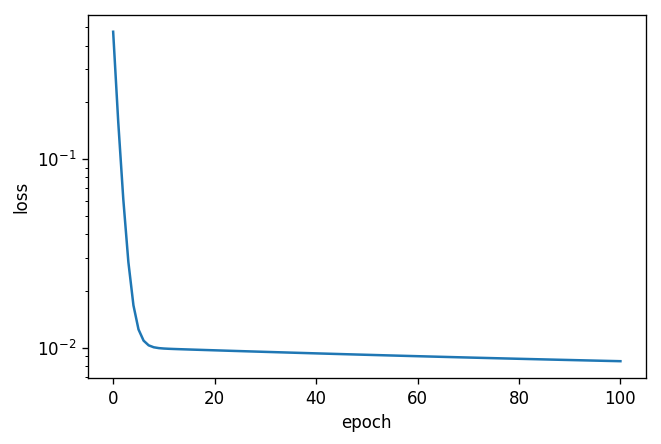

CPU times: user 1min 35s, sys: 2.07 s, total: 1min 37s
Wall time: 37.5 s


In [204]:
# Power Consumption Data
%time train_gd(batch_size=N_p, lr=0.2, epochs=100, period=N_p, layers=[5,4], features = p_features, labels = p_labels)

w: [[ 0.03480289 -0.499755   -0.9564009  ... -0.22647053  0.79589057
  -1.3140944 ]] b: -0.037221953 

201


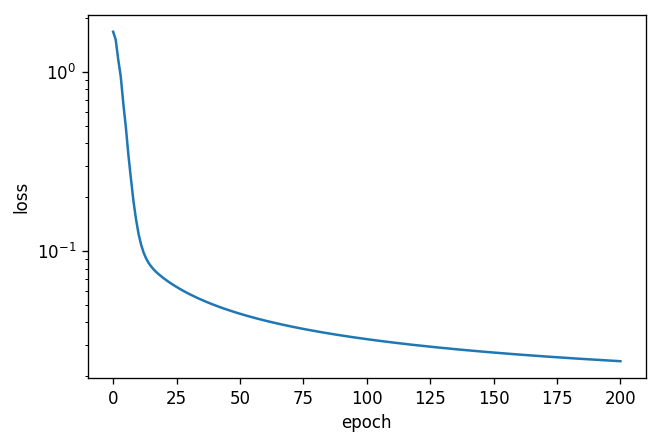

CPU times: user 18.9 s, sys: 133 ms, total: 19 s
Wall time: 4.76 s


In [208]:
# Communities and crime data
%time train_gd(batch_size=N_c, lr=0.1, epochs=200, period=N_c, layers=[30,5], features = c_features, labels = c_labels)

# MiniBatch

In [147]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

# update function
def sgd(params, states, hyperparams): 
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad
        
def pgd(params, states, hyperparams):
    for p in params:
        p[:] -= hyperparams['lr'] * (p.grad + mx.nd.random.uniform(-0.2,0.2, p.grad.shape))
        
def bcd(params, states, hyperparams):
    for p in params:
        factor = np.random.randint(2, size=p.grad.shape)
        factor = mx.nd.array(factor)
        p[:] -= hyperparams['lr'] * nd.multiply(p.grad, factor)
            
def trainer(trainer_fn, states, hyperparams, features, labels, period,
batch_size, num_epochs, layers):# Initialization
    assert period >= batch_size and period % batch_size == 0
    num_inputs, num_outputs, num_hiddens_1, num_hiddens_2 = features.shape[1], 1, layers[0], layers[1]
    W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens_1))
    W2 = nd.random.normal(scale=0.01, shape=(num_hiddens_1, num_hiddens_2))
    W3 = nd.random.normal(scale=0.01, shape=(num_hiddens_2, num_outputs))
    params = [W1, W2, W3] 
    
    # square loss
    square_loss = gluon.loss.L2Loss()
    for param in params:
        param.attach_grad()
    
    def sigmoid(X):
        return nd.sigmoid(X)
    
    def net(X):
        X = X.reshape((-1, num_inputs))
        H1 = sigmoid(nd.dot(X, W1))
        H2 = sigmoid(nd.dot(H1, W2))
        return nd.dot(H2, W3)
   
    total_loss = [np.mean(square_loss(net(features), labels).asnumpy())]
    data_iter = gdata.DataLoader(gdata.ArrayDataset(features, labels), batch_size, shuffle=True) 
    for _ in range(num_epochs):
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer_fn([W1, W2, W3], states, hyperparams) # Update Model Params
            #if batch_i * batch_size % period == 0:
                #total_loss.append(np.mean(square_loss(net(features), labels).asnumpy()))
            total_loss.append(np.mean(square_loss(net(features), labels).asnumpy()))
    
    print(len(total_loss))
    print('w1:', np.reshape(W1.asnumpy(), (1, -1)),
          'w2:', np.reshape(W2.asnumpy(), (1, -1)),
          'w3:', np.reshape(W3.asnumpy(), (1, -1)),'\n')
    x_axis = np.linspace(0, num_epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def train_p(solver ,lr, batch_size, period, num_epochs, layers):
    if solver == sgd:
        trainer(sgd, None, {'lr': lr}, p_features, p_labels, period, batch_size, num_epochs, layers)
    elif solver == pgd:
        trainer(pgd, None, {'lr': lr}, p_features, p_labels, period, batch_size, num_epochs, layers)
    elif solver == bcd:
        trainer(bcd, None, {'lr': lr}, p_features, p_labels, period, batch_size, num_epochs, layers)
    elif solver == gd:
        trainer(gd, None, {'lr': lr}, p_features, p_labels, period, batch_size, num_epochs, layers)
        
def train_c(solver ,lr, batch_size, period, num_epochs, layers):
    if solver == sgd:
        trainer(sgd, None, {'lr': lr}, c_features, c_labels, period, batch_size, num_epochs, layers)
    elif solver == pgd:
        trainer(pgd, None, {'lr': lr}, c_features, c_labels, period, batch_size, num_epochs, layers)
    elif solver == bcd:
        trainer(bcd, None, {'lr': lr}, c_features, c_labels, period, batch_size, num_epochs, layers)
    elif solver == gd:
        trainer(gd, None, {'lr': lr}, c_features, c_labels, period, batch_size, num_epochs, layers)

520
w1: [[-1.5561082  -1.5746822  -1.5134339  -1.52638    -1.5302172  -0.26890957
  -0.28600514 -0.28212744 -0.2557914  -0.26341784  0.23073308  0.25024378
   0.23457094  0.23749442  0.2532693  -1.4956226  -1.5052675  -1.4517416
  -1.4514682  -1.4628149   0.11807939  0.1122357   0.1281286   0.12492096
   0.12700768  0.20709838  0.21037278  0.2286593   0.24206555  0.26173198
  -0.07826821 -0.08885655 -0.02987953 -0.03848514 -0.03458722]] w2: [[-1.1489464 -1.2116472 -1.0966768 -1.1878793 -1.1683562 -1.1948292
  -1.1060809 -1.221343  -1.1394335 -1.1735686 -1.0930514 -1.1801366
  -1.1399438 -1.1929692 -1.0903866 -1.1750306 -1.1513493 -1.194629
  -1.0901301 -1.1944127]] w3: [[0.30813083 0.6275975  0.09616296 0.608605  ]] 



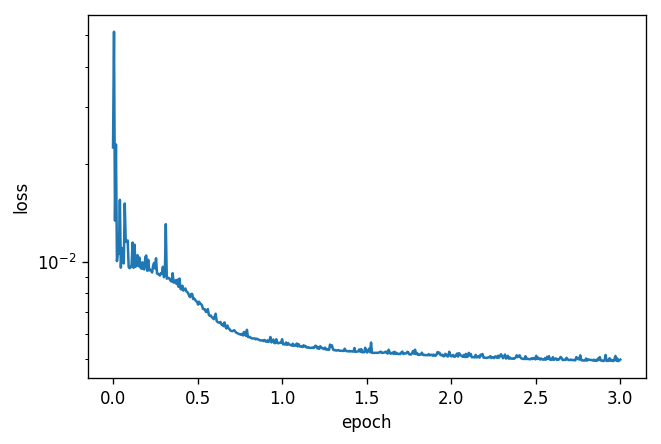

In [52]:
# Power Consumption Data
train_p(sgd, lr=0.2, batch_size=10, period=200, num_epochs=3, layers=[5,4])

31
w1: [[-0.0456793  -0.05274796 -0.05726865 ... -0.08284027 -0.10071627
  -0.09110807]] w2: [[-0.19706422 -0.20513824 -0.20699313 -0.21615927 -0.22346067 -0.19611084
  -0.1902928  -0.19407837 -0.18446073 -0.18953738 -0.25770274 -0.22377509
  -0.23448227 -0.2435921  -0.23627394 -0.17326103 -0.17972493 -0.18265826
  -0.18547735 -0.16171096 -0.19434355 -0.21946669 -0.19836482 -0.19748151
  -0.21941788 -0.20697594 -0.22590248 -0.23677933 -0.22814605 -0.23412436
  -0.18816552 -0.17257912 -0.18721762 -0.16952743 -0.17993277 -0.17106427
  -0.18757848 -0.17298272 -0.17855054 -0.1751958  -0.19951908 -0.21742156
  -0.21335043 -0.21942091 -0.2148777  -0.22929789 -0.23535432 -0.24205375
  -0.23932734 -0.24166696 -0.2346507  -0.21116482 -0.23808596 -0.21579923
  -0.20483151 -0.22814953 -0.20816728 -0.23322904 -0.20194264 -0.21914093
  -0.19669364 -0.18255274 -0.1718587  -0.17782985 -0.16909362 -0.21938786
  -0.23027378 -0.21174544 -0.21840054 -0.20317788 -0.19736025 -0.1909949
  -0.21217626 -0.225

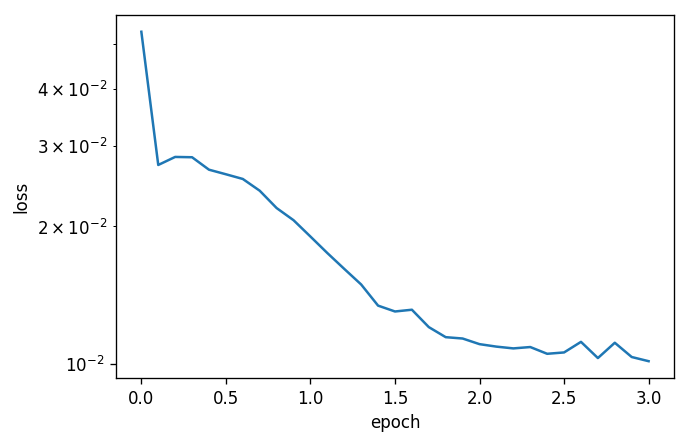

In [39]:
# Communities and crime data
train_c(sgd, lr=0.2, batch_size=10, period=200, num_epochs=3, layers=[30,5])

# Perturbed GD

520
w1: [[-1.6707232   2.9342225   0.95657325 -5.134658    2.898654   -2.438731
  -2.421827   -1.5970914  -1.1106246   1.042821    0.660326   -1.3238229
   1.1564268  -0.17630023 -0.20443043  1.5059056   0.7572904   1.5134113
   0.02995368  2.9859114   1.9845289  -1.3696754   1.4273105  -3.5980537
  -0.11815715  1.2885233  -2.5870779   0.45222172 -1.1888468   2.9505837
  -3.7734275  -1.1925275   1.7701863   0.70241445 -0.4354146 ]] w2: [[-1.8352945  -0.5251444  -3.1891866  -1.8462636  -5.459249   -2.8739004
  -2.7490308   0.88505024 -2.0683415  -2.428822   -1.715577   -1.5624377
  -2.4585896   1.2463273  -2.0202663  -4.0877147   3.082452   -1.7610085
  -0.12768498  1.8386723 ]] w3: [[ 0.03528465  0.3597696  -2.8366966   1.0026679 ]] 



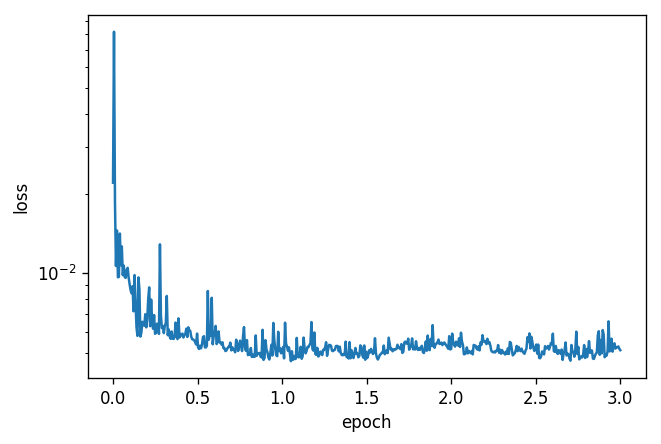

In [40]:
# Power Consumption Data
train_p(pgd, lr=0.2, batch_size=10, period=200, num_epochs=3, layers=[5,4])

31
w1: [[ 1.411222    0.45141557 -0.28537768 ...  1.2158235  -0.11995685
  -0.9713031 ]] w2: [[ 0.06158647 -0.00667174  0.61366385 -0.53453946 -0.9298424   0.05857956
   0.11507769 -0.3486347  -0.25539234 -0.12197893  0.3084488  -0.7028503
   0.7949426   0.7822129   0.91979223  0.7907369  -0.80872935 -0.3724044
   0.3567939  -0.60630876 -0.26869702 -0.47454563  0.09583952 -0.5785914
  -0.43584883  0.38816068 -1.4004109  -0.14750808 -1.4772142  -0.26247552
  -0.85711473  0.76328844 -0.779414    0.06600517  0.44300193 -0.87585676
  -0.07599845 -0.86050034  0.08933964 -0.27317497  0.5088603  -0.66877747
   0.20976986 -0.3215399   0.20658483  0.70786464  0.05760144  0.92386025
  -0.3524915   0.77169365  0.12223813  0.6273543  -0.02869055 -0.01109244
  -0.78921777 -0.21846643 -0.10426097 -0.11416958 -0.580812   -0.318232
   0.17911632 -0.04721811 -0.484761   -0.29184732 -0.09523754  0.04369967
   0.08019151  0.54175645  1.2203119  -0.27084887  0.9556745   0.05462841
   0.4025374   0.0225260

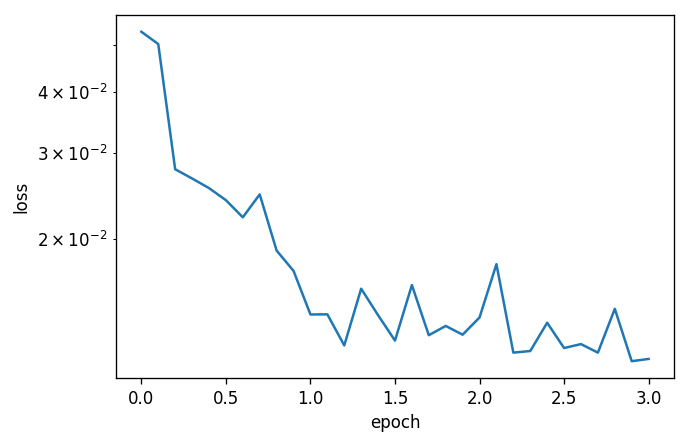

In [43]:
# Communities and crime data
train_c(pgd, lr=0.2, batch_size=10, period=200, num_epochs=3, layers=[30,5])

# BCD

10378
w1: [[-0.02278363  0.09537955 -0.43010348 -1.350166   -1.5010996  -0.10099933
  -0.04755593 -0.13513713 -0.23441376 -0.12366723  0.12201186  0.00195278
  -0.22234961  0.23455735  0.00182718 -0.11577638 -0.00240504 -0.5637267
  -1.1937635  -1.3857813  -0.23124233 -0.41145214  0.12017336  0.35400426
   0.19772923 -0.15396391 -0.4265807   0.12919831  0.28902274  0.05328949
  -0.33824626 -0.44030654 -0.34891737  0.11188363 -0.23886937]] w2: [[-1.8519071  -1.0063752  -0.5937492  -0.4616455  -1.2026582  -0.27806512
  -1.0835328   0.3144281  -0.08379286 -0.85313725 -0.52367187 -0.7222305
  -0.5460099  -1.4424423   0.43616283 -0.79259497  0.02640222 -0.778918
   0.21115477 -0.7439861 ]] w3: [[-2.2751298  2.2109675 -1.3239893  2.3647373]] 



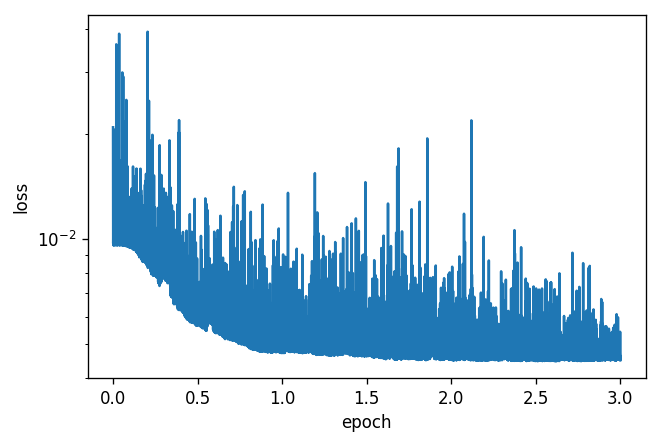

In [148]:
# Power Consumption Data
train_p(bcd, lr=0.2, batch_size=10, period=200, num_epochs=3, layers=[5,4])

601
w1: [[-0.0027463   0.05143877 -0.00869805 ... -0.05185192 -0.08191533
  -0.0374807 ]] w2: [[ 0.1411989  -0.11890723 -0.05454078 -0.12247103 -0.00550258  0.61426634
  -0.05082466  0.00987022 -0.13911825  0.38717657  0.12249602 -0.03672347
  -0.06311502 -0.0640801   0.16838251 -0.4174573  -0.0803411  -0.27369434
  -0.00915885 -0.18311055 -0.09786154 -0.06555051 -0.03600406 -0.03802715
  -0.08095359 -0.2014939  -0.04004216 -0.16496634 -0.11398455  0.03747309
  -0.18173791 -0.06163091 -0.13236703 -0.15074156  0.12677574 -0.25121844
  -0.04959958 -0.3011576  -0.12229619 -0.34450424 -0.48451173  0.0063367
  -0.46975335 -0.01900748 -0.5541394  -0.08384322 -0.06431396 -0.25745994
  -0.05637871 -0.4023861  -0.35961792  0.01993495 -0.31644875 -0.13152632
  -0.29596058  0.05968736 -0.14218038  0.02848376 -0.05961521  0.34397596
  -0.10920209 -0.10104381 -0.05700434 -0.03710021 -0.19880305 -0.07843935
  -0.02983105 -0.14263712 -0.12897636 -0.09464199 -0.25198692 -0.10515261
  -0.20268215 -0.10

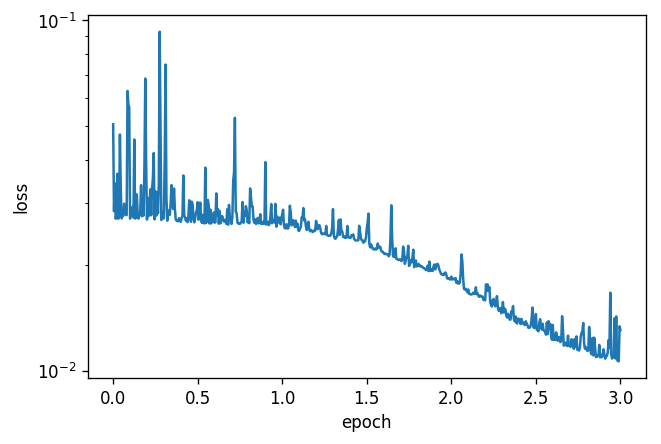

In [149]:
# Power Consumption Data
train_c(bcd, lr=0.2, batch_size=10, period=200, num_epochs=3, layers=[30,5])

# SVRG

In [127]:
def svrg(params, states, hyperparams, w): 
    for i, p in enumerate(params):
        p[:] -= hyperparams['lr'] * (p.grad + w[i])
            
def train(trainer_fn, states, hyperparams, features, labels, period,
batch_size, num_epochs, layers): # initialization
    assert period >= batch_size and period % batch_size == 0
    num_inputs, num_outputs, num_hiddens_1, num_hiddens_2 = features.shape[1], 1, layers[0], layers[1]
    W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens_1))
    W2 = nd.random.normal(scale=0.01, shape=(num_hiddens_1, num_hiddens_2))
    W3 = nd.random.normal(scale=0.01, shape=(num_hiddens_2, num_outputs))
    params = [W1, W2, W3] 
    
    for param in params:
        param.attach_grad()
    
    def sigmoid(X):
        return nd.sigmoid(X)
    
    def net(X):
        X = X.reshape((-1, num_inputs))
        H1 = sigmoid(nd.dot(X, W1))
        H2 = sigmoid(nd.dot(H1, W2))
        return nd.dot(H2, W3)
   
    square_loss = gluon.loss.L2Loss()
    total_loss = [np.mean(square_loss(net(features), labels).asnumpy())]
    data_iter = gdata.DataLoader(gdata.ArrayDataset(features, labels), batch_size, shuffle=True) 
    for _ in range(num_epochs):
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            w_g = [W1.grad, W2.grad, W3.grad]
            with autograd.record():
                output = net(features)
                loss = square_loss(output, labels)
            w_all = [W1.grad.mean(), W2.grad.mean(), W3.grad.mean()]
            w = [a-b for a, b in zip(w_g, w_all)]
            rand = random.randint(0, len(features)%batch_size-1)
            with autograd.record():
                output = net(data[rand])
                loss = square_loss(output, label[rand])
            loss.backward()
            trainer_fn([W1, W2, W3], states, hyperparams, w) # update param 
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(features), labels).asnumpy())) # every period record the loss
    
    print(len(total_loss))
    print('w1:', np.reshape(W1.asnumpy(), (1, -1)),
          'w2:', np.reshape(W2.asnumpy(), (1, -1)),
          'w3:', np.reshape(W3.asnumpy(), (1, -1)),'\n')
    x_axis = np.linspace(0, num_epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

19
w1: [[ 0.05072119  0.05786957  0.04072005  0.04385624  0.02454057 -0.0490601
  -0.04015028 -0.03126587 -0.04646449 -0.03713882 -0.07539023 -0.07716154
  -0.09397111 -0.07920389 -0.07535532  0.0552632   0.05293727  0.03982414
   0.05378665  0.0317336  -0.02457175 -0.03044677 -0.03233882 -0.03815833
  -0.02736858 -0.03494951 -0.03192799 -0.02604437 -0.02163722 -0.0336865
   0.10215676  0.10777934  0.09685451  0.12030175  0.06565327]] w2: [[ 1.39377594e-01 -7.85494037e-03 -1.46703925e-02 -1.07587256e-01
   1.46963507e-01 -5.55969588e-03 -8.18551611e-03 -1.08913168e-01
   1.35619208e-01 -5.64453985e-05 -3.34163904e-02 -9.43281874e-02
   1.49269775e-01 -7.55983172e-03 -3.20428312e-02 -1.20263286e-01
   9.65992734e-02  1.56611856e-02 -1.28841316e-02 -7.60228783e-02]] w3: [[ 0.35932234  0.04585692  0.00495709 -0.18008533]] 



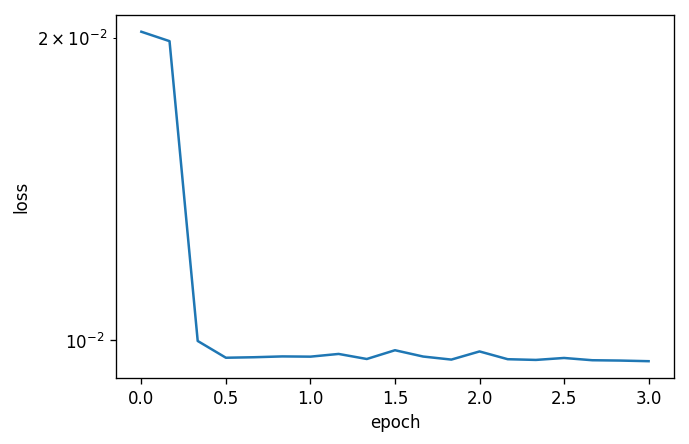

In [139]:
train(svrg, None, {'lr': 0.02}, p_features, p_labels, period=6400, batch_size=64, num_epochs=3, layers=[5,4])

801
w1: [[ 0.01201004  0.00066307  0.01752743 ...  0.02150705  0.01194878
  -0.01042745]] w2: [[-3.49515560e-03  1.02617750e-02  5.35748186e-05  5.43403765e-03
  -3.87886539e-03 -4.03013173e-03 -1.34152558e-03 -4.31420002e-03
  -1.16805732e-03  7.76367728e-03  4.01609810e-03  1.43855792e-02
   1.36332577e-02 -1.43228250e-03 -3.23494663e-03 -7.64439860e-03
   5.08197676e-03  6.18610252e-03 -5.82975661e-03 -6.27712507e-05
  -1.49214976e-02  5.77313825e-03  6.05708128e-03  1.34404954e-02
   8.25749058e-03  3.26750963e-03 -1.48483319e-03  2.83071920e-02
  -6.11612666e-03  2.35711667e-03 -9.37124621e-03  4.53563593e-03
  -6.40559429e-03 -1.11934287e-03  2.63430085e-03  3.85663006e-03
   1.24797774e-02  2.01107636e-02 -2.43185833e-03  1.43264681e-02
  -2.32696813e-03 -2.30259891e-03 -5.41843846e-03  1.28515540e-02
   4.38063499e-03  9.33003612e-03 -5.29280351e-03 -4.47683316e-03
   5.92700485e-03 -1.15847299e-02 -1.49461329e-02 -1.17097422e-02
  -1.56295076e-02 -3.05386656e-03  5.60643384e-0

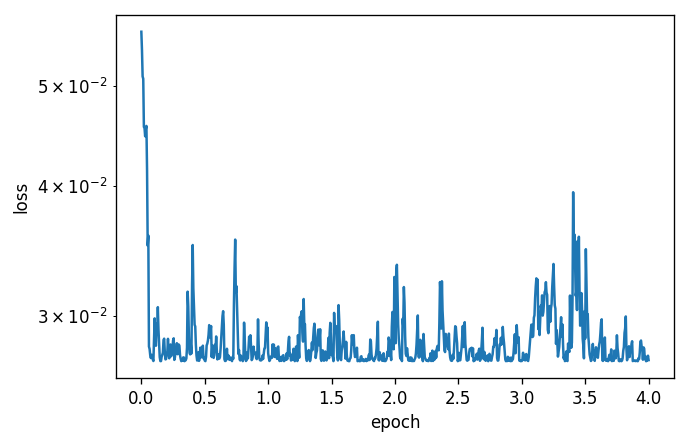

In [138]:
train(svrg, None, {'lr': 0.02}, c_features, c_labels, period=10, batch_size=10, num_epochs=4, layers=[40,20])